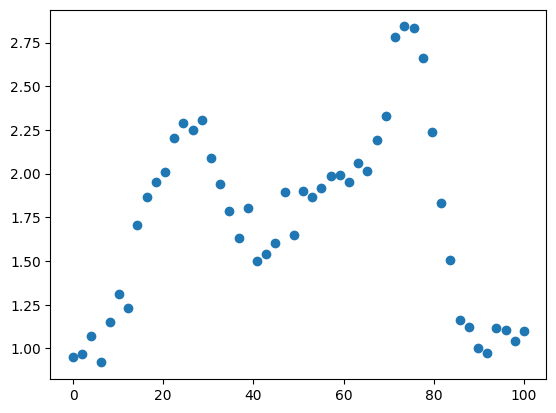

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for 3 Gaussians
means = [25, 58, 75]
stds = [8, 12, 5]
weights = [0.25, 0.3, 0.2]

def generate_data(n_samples):
    x_samples = np.linspace(0, 100, n_samples)

    def get_mixture_density(x_vals):
        return 100 * sum(w * (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - m) / s) ** 2) 
                   for m, s, w in zip(means, stds, weights))

    y_true = get_mixture_density(x_samples)

    # 3. Add lognormal noise
    noise = np.random.lognormal(mean=0, sigma=0.1, size=n_samples)

    y_samples = y_true + noise
    
    # Return as a 2D array (n_samples, 2)
    return np.column_stack((x_samples, y_samples))

# Example usage
data = generate_data(50)
plt.scatter(data[:, 0], data[:,1])

In [2]:
import numpy as np

class SLR:
    def __init__(self, lr, reg, degree, w_init=None):
        self.lr = lr
        self.reg = reg
        self.degree = degree
        
        if w_init is None:
            self.w = np.random.randn(degree + 1) * 0.01
        else:
            self.w = w_init

    def basis(self, x):
        # Creates polynomial basis [1, x, x^2, ..., x^M]
        return np.array([x**i for i in range(self.degree + 1)])

    def forward(self, x):
        Phi = self.basis(x)  # shape: (degree+1,)
        return Phi @ self.w  # dot product -> scalar prediction

    def loss(self, t, y):
        # Log-normal loss + L2 regularizer
        residual = t - y
        loss_val = np.sum(np.log(residual)**2)
        reg_term = self.reg * np.dot(self.w, self.w)
        return loss_val + reg_term

    def step(self, x, t):
        # *** YOU will compute gradient of loss here ***
        # forward pass
        y = self.forward(x)
        
        # compute gradients: dL/dw_j
        residual = t - y
        grad_base = -2 * np.log(residual) * (1 / residual)  # derivative wrt y
        Phi = self.basis(x)
        grad_w = grad_base * Phi + 2 * self.reg * self.w
        
        # SGD update
        self.w -= self.lr * grad_w


class Trainer:
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs

    def fit(self, model, train_data):
        for epoch in range(self.num_epochs):
            for x, t in train_data:
                model.step(x, t)

    def predict(self, model, x):
        return model.forward(x)


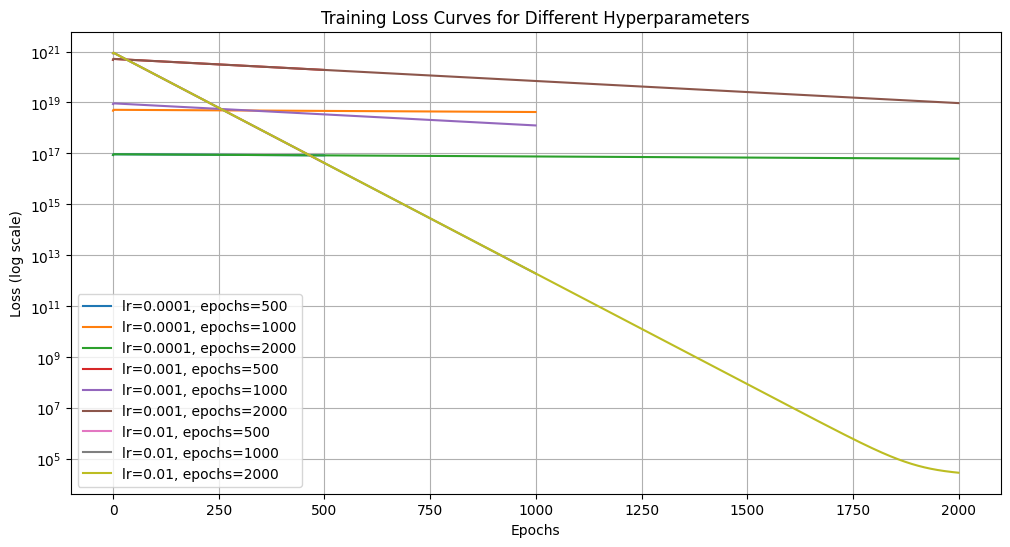

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------
# FIXED: stable log-residual calculation (Q1 fix)
def stable_residual(t, y, eps=1e-8):
    # ensures positivity for log computation
    return np.clip(t - y, eps, None)
# ----------------------------------------------


# -------- UPDATE YOUR MODEL CLASS ---------
# (only showing loss and step — leave the rest as you wrote)

class SLR:
    def __init__(self, lr, reg, degree, w_init=None):
        self.lr = lr
        self.reg = reg
        self.degree = degree
        
        # Initialize weights
        if w_init is None:
            self.w = np.random.randn(degree + 1) * 0.01
        else:
            self.w = w_init
    
    # polynomial basis
    def basis(self, x):
        return np.array([x**i for i in range(self.degree + 1)])
    
    # forward model
    def forward(self, x):
        return self.basis(x) @ self.w
    
    # ------ LOSS with stable log-residual ------
    def loss(self, t, y):
        residual = stable_residual(t, y)
        loss_val = np.sum(np.log(residual)**2)
        reg_term = self.reg * np.dot(self.w, self.w)
        return loss_val + reg_term
    
    # ------ ONE STEP OF SGD ------
    def step(self, x, t):
        y = self.forward(x)
        residual = stable_residual(t, y)
        
        # derivative of squared log residual wrt y
        grad_base = -2 * np.log(residual) * (1 / residual)
        Phi = self.basis(x)
        
        # gradient wrt weights
        grad_w = grad_base * Phi + 2 * self.reg * self.w
        
        # SGD update
        self.w -= self.lr * grad_w


# -------- TRAINER (no change from earlier) --------
class Trainer:
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs
    
    def fit(self, model, train_data):
        for epoch in range(self.num_epochs):
            for x, t in train_data:
                model.step(x, t)
    
    def predict(self, model, x):
        return model.forward(x)



# =====================================================
#        PART 3 — Q1: Hyperparameter Experimentation
# =====================================================

learning_rates = [1e-4, 1e-3, 1e-2]   # will test these
epochs_list     = [500, 1000, 2000]   # and these

train_data = generate_data(50)        # fixed dataset

plt.figure(figsize=(12,6))

for lr in learning_rates:
    for ep in epochs_list:
        model = SLR(lr=lr, reg=0.01, degree=5)
        loss_history = []

        for epoch in range(ep):
            total_loss = 0
            for x, t in train_data:
                y = model.forward(x)
                total_loss += model.loss(t, y)
                model.step(x, t)
            loss_history.append(total_loss)

        plt.plot(range(ep), loss_history, label=f"lr={lr}, epochs={ep}")

plt.yscale('log')                # ← key line
# plt.ylim(1e-6, 1)              # optional zoom
# plt.xlim(0, 300)               # optional zoom

plt.title("Training Loss Curves for Different Hyperparameters")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True)
plt.show()

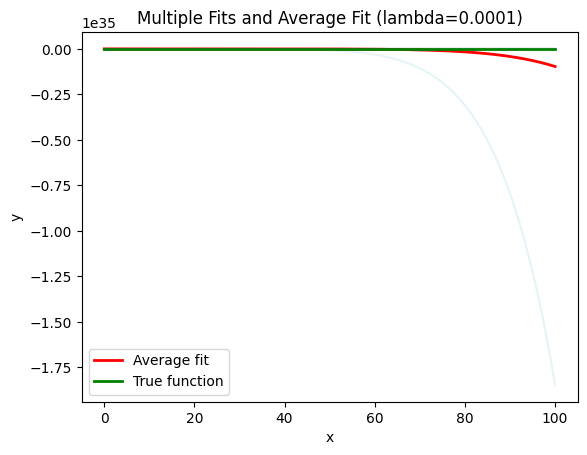

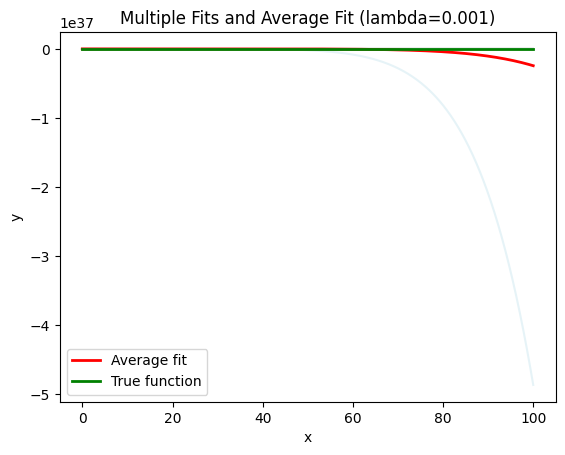

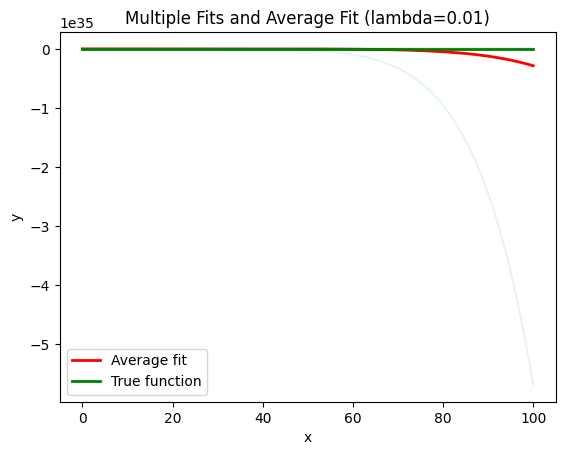

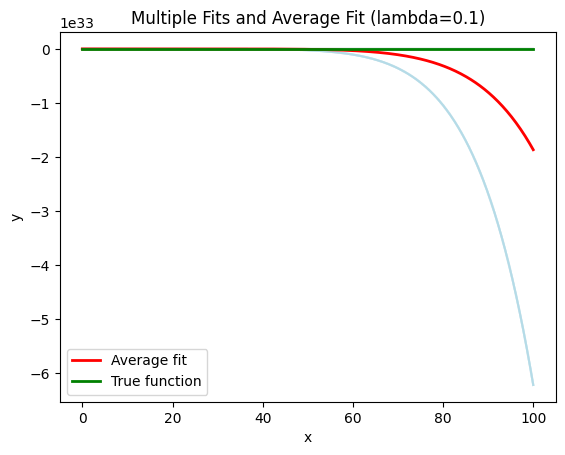

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- true function for plotting (same as used in generate_data) ----
def true_function(x_vals):
    return 100 * sum(w * (1/(s*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x_vals-m)/s)**2)
                     for m, s, w in zip(means, stds, weights))


# ----- Experiment Setup -----
lambdas = [0.0001, 0.001, 0.01, 0.1]   # test multiple values
num_datasets = 20
n_samples = 50

x_dense = np.linspace(0, 100, 500)     # smoother curve than training xs
y_true_dense = true_function(x_dense)


for lam in lambdas:
    fits = []  # store predictions from each dataset
    
    for i in range(num_datasets):
        data = generate_data(n_samples)
        model = SLR(lr=0.001, reg=lam, degree=8)  # degree=8 typically works well
        trainer = Trainer(num_epochs=2000)
        trainer.fit(model, data)
        
        # predict over dense grid
        y_pred_dense = np.array([trainer.predict(model, x) for x in x_dense])
        fits.append(y_pred_dense)
        
        # plot individual fits faintly
        plt.plot(x_dense, y_pred_dense, color='lightblue', alpha=0.3)

    # compute mean of predictions
    avg_fit = np.mean(fits, axis=0)

    # plot average fit + true function
    plt.plot(x_dense, avg_fit, color='red', linewidth=2, label='Average fit')
    plt.plot(x_dense, y_true_dense, color='green', linewidth=2, label='True function')

    plt.title(f"Multiple Fits and Average Fit (lambda={lam})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

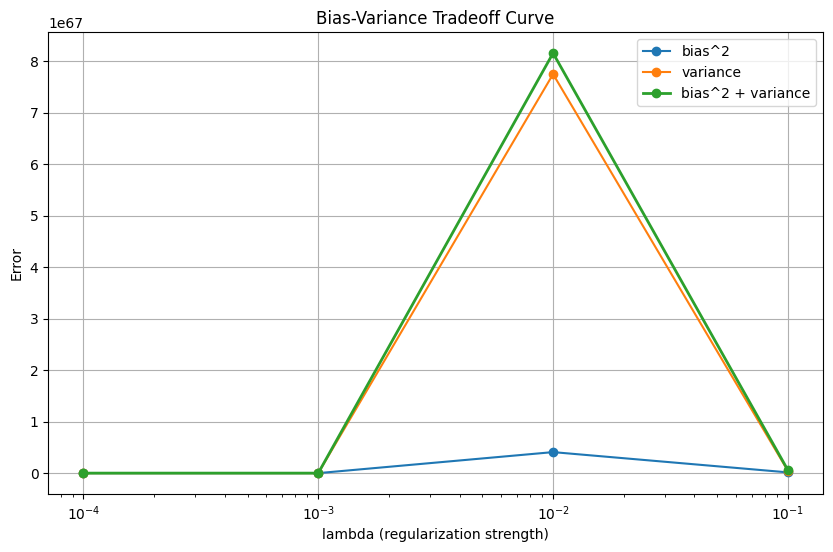

Optimal lambda = 0.001


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# Experiment setup
# -----------------------------------------------------
lambdas = [0.0001, 0.001, 0.01, 0.1]  # same values as Q2
num_datasets = 20
degree = 8
epochs = 2000
lr = 0.001

# Dense x grid to evaluate functions
x_dense = np.linspace(0, 100, 500)
y_true_dense = true_function(x_dense)

bias_list = []
variance_list = []
total_list = []

# -----------------------------------------------------
# Main loop: compute bias and variance for each lambda
# -----------------------------------------------------
for lam in lambdas:
    fits = []

    for i in range(num_datasets):
        data = generate_data(50)
        model = SLR(lr=lr, reg=lam, degree=degree)
        trainer = Trainer(num_epochs=epochs)
        trainer.fit(model, data)

        y_pred_dense = np.array([trainer.predict(model, x) for x in x_dense])
        fits.append(y_pred_dense)

    fits = np.array(fits)              # shape (20, N_x)
    avg_fit = np.mean(fits, axis=0)    # μ(x)

    # ---- compute bias^2 ----
    bias_sq = np.mean((avg_fit - y_true_dense)**2)
    bias_list.append(bias_sq)

    # ---- compute variance ----
    variance = np.mean(np.mean((fits - avg_fit)**2, axis=0))
    variance_list.append(variance)

    # ---- total error ----
    total_list.append(bias_sq + variance)

# -----------------------------------------------------
# Plot bias^2, variance, and total error
# -----------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(lambdas, bias_list, marker='o', label='bias^2')
plt.plot(lambdas, variance_list, marker='o', label='variance')
plt.plot(lambdas, total_list, marker='o', label='bias^2 + variance', linewidth=2)
plt.xscale('log')
plt.xlabel("lambda (regularization strength)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff Curve")
plt.legend()
plt.grid(True)
plt.show()

# print optimal lambda
optimal_lambda = lambdas[np.argmin(total_list)]
print("Optimal lambda =", optimal_lambda)
